In [1]:
from mflex.simulate.simulate_boundary import dipole, dipole_large
import numpy as np
from mflex.model.field.bfield_model import (
    magnetic_field,
    bz_partial_derivatives,
    magnetic_field_low,
    bz_partial_derivatives_low,
)
from mflex.plot.plot_magnetogram import plot_fieldlines_polar, plot_fieldlines_polar_large
from mflex.plot.plot_plasma_parameters import plot_deltaparam
import matplotlib.pyplot as plt
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
    pres,
    den,
    temp,
    deltaden_low,
    deltapres_low,
)
from mflex.model.field.utility.height_profile import f_low, f

In [2]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 2.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 2.0
zmin = 0.0
zmax = 1.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z
nf_max = 200
L = 1.0
print(xmin, ymin, zmin)
print(xmax, ymax, zmax)
print(pixelsize_x, pixelsize_y, pixelsize_z)

# Background atmosphere parameters
z0 = 0.2
deltaz = 0.02

# Height profile f parameters
a = 0.2
alpha = 0.5
b = 1.0

# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02
a_low = a * (1 - np.tanh(-z0_b / deltaz_b))
kappa = 1.0 / z0_b
deltaz_low = 2.0 / kappa

0.0 0.0 0.0
2.0 2.0 1.0
0.01 0.01 0.0025


In [3]:
# Fieldline3D parameters
h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

print("Atmospheric z0", z0)
print("Atmospheric Delta z", deltaz)
print("Magnetic field z0", z0_b)
print("Magnetic field Delta z", deltaz_b)

t_photosphere = 5600.0  # Temperature at z = 0 (on photosphere) in Kelvin
t_corona = 2.0 * 10.0**6  # Temperature at z = 2.0 (at 20 Mm) in Kelvin
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (
    1.0 + np.tanh(z0 / deltaz)
)  # Temperature at z = z0 in Kelvin
t1 = (t_corona - t_photosphere) / (
    1.0 + np.tanh(z0 / deltaz)
)  # t_corona - t0 in Kelvin
g_solar = 274.0  # gravitational acceleration in m/s^2
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 * 10**-1
)  # pressure scale height in 10^4 km (10**-6 to convert to Mm, and 10**-1 to convert to 10Mm = 10^4 km)
rho0 = 3.0 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = 100.0  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
h_photo = h / t0 * t_photosphere

print("Temperature Photosphere", t_photosphere)
print("Temperature Corona", t_corona)
print("T0", t0)
print("T1", t1)
print("g", g_solar)
print("mbar", mbar)
print("Pressure Scale height z0", h)
print("Pressure Scale height photosphere", h_photo)
print("Plasma Density Photosphere", rho0)
print("Magnetic field strength Photosphere", b0)
print("Plasma Pressure Photosphere", p0)
print("Magnetic Pressure Photosphere", pB0)
print("Plasma Beta", beta0)
print("Density scaling", 0.5 * beta0 / h * t0 / t_photosphere)

Atmospheric z0 0.2
Atmospheric Delta z 0.02
Magnetic field z0 0.2
Magnetic field Delta z 0.02
Temperature Photosphere 5600.0
Temperature Corona 2000000.0
T0 1002799.9979446176
T1 997200.0020553825
g 274.0
mbar 1.6726200000000002e-27
Pressure Scale height z0 3.020993277041208
Pressure Scale height photosphere 0.016870325474776363
Plasma Density Photosphere 0.00030000000000000003
Magnetic field strength Photosphere 100.0
Plasma Pressure Photosphere 13867.407540266171
Magnetic Pressure Photosphere 39.7887358184391
Plasma Beta 348.52596482443823
Density scaling 10329.556633200002


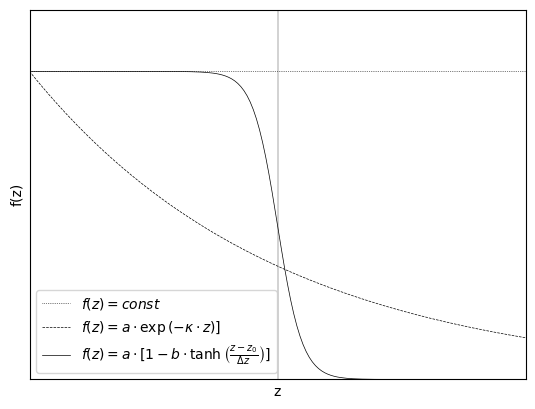

In [4]:
# Figure 1
z_arr: np.ndarray[np.float64, np.dtype[np.float64]] = (
    np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
)

f_const = np.zeros(nresol_z)
f_exp = np.zeros(nresol_z)
f_tanh = np.zeros(nresol_z)

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f_const[iz] = a * (1 - np.tanh(-z0_b / deltaz_b))
    f_exp[iz] = f_low(z, a_low, kappa)
    f_tanh[iz] = f(z, z0_b, deltaz_b, a, b)


plt.plot(
    z_arr,
    f_const,
    label=r"$f(z) = const$",
    linewidth=0.5,
    color="black",
    linestyle="dotted",
)
plt.plot(
    z_arr,
    f_exp,
    label=r"$f(z) = a \cdot \exp\left(- \kappa \cdot z \right)]$",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    f_tanh,
    label=r"$f(z) = a \cdot [1 - b \cdot \tanh\left(\frac{z - z_0}{\Delta z}\right)]$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.axvline(x=z0_b, color="black", linestyle="solid", linewidth=0.25)
plt.legend()
plt.xlabel("z")
plt.ylabel("f(z)")
plt.xlim([0.0, 2 * z0_b])
plt.ylim([0.0, 1.2 * (a * (1 - np.tanh(-z0_b / deltaz_b)))])
plt.xticks([])
plt.yticks([])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure1.png"
# plt.savefig(plotname, dpi=300)
plt.show()

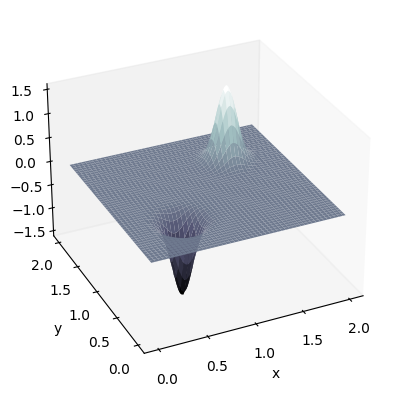

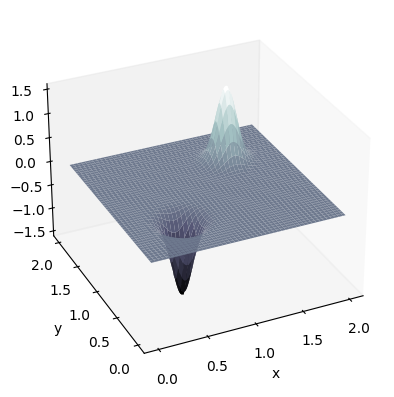

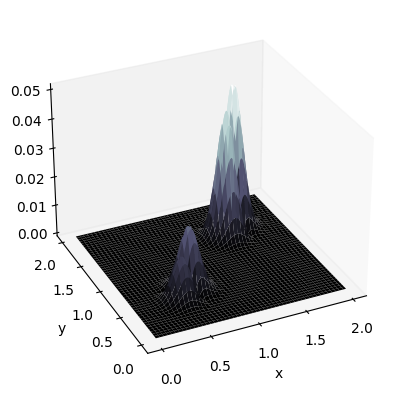

In [5]:
# Figure 2

x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(y_plot, x_plot, data_bz, cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, -115, 0)
ax.grid(False)
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure2a.png"
# plt.savefig(plotname, dpi=300)
plt.show()

a_fig2b = 0.2
alpha_fig2b = 0.5
z0_b_fig2b = 0.2
deltaz_b_fig2b = 0.02

bfield, dbfield = magnetic_field(
    data_bz,
    z0_b_fig2b,
    deltaz_b_fig2b,
    a_fig2b,
    b,
    alpha_fig2b,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

b_back = np.zeros((2 * nresol_y, 2 * nresol_x))
b_back = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, 0, 2]

# Figure 2b

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(y_plot, x_plot, b_back, cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, -115, 0)
ax.grid(False)
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure2b.png"
# plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(y_plot, x_plot, abs(data_bz - b_back), cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, -115, 0)
ax.grid(False)
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure2b.png"
# plt.savefig(plotname, dpi=300)
plt.show()

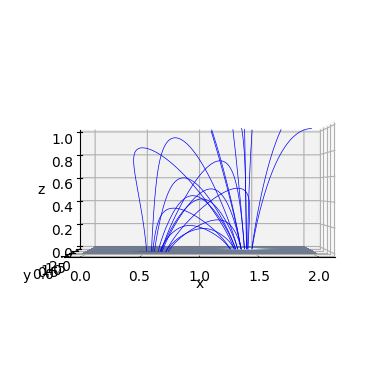

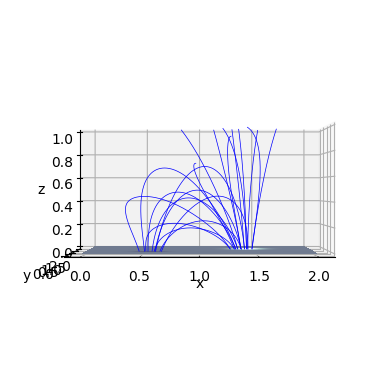

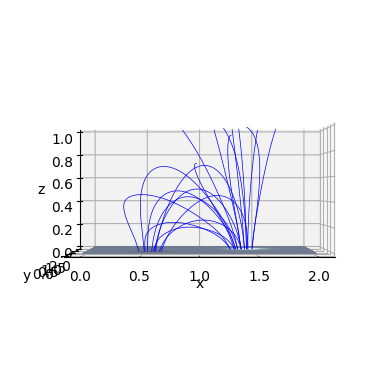

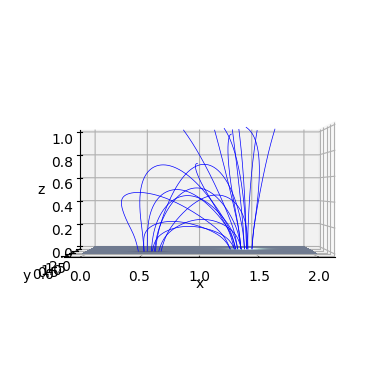

In [6]:
# Figures 3 and 4

# Potential parameters

a0 = 0.0
alpha0 = 0.0

# Linear force free parameters

a1 = 0.0
alpha1 = 0.5

# Magnetohydristatic parameters 1

a2 = 0.2
alpha2 = 0.5
# Magnetohydrostatic parameters 2

a3 = 0.4
alpha3 = 0.5

bfield0, dbfield0 = magnetic_field(
    data_bz,
    z0_b,
    deltaz,
    a0,
    b,
    alpha0,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

bfield1, dbfield1 = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a1,
    b,
    alpha1,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

bfield2, dbfield2 = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a2,
    b,
    alpha2,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

bfield3, dbfield3 = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a3,
    b,
    alpha3,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

plot_fieldlines_polar(
    bfield0,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a0,
    b,
    alpha0,
    nf_max,
    name="0",
)

plot_fieldlines_polar(
    bfield1,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a1,
    b,
    alpha1,
    nf_max,
    name="1",
)

plot_fieldlines_polar(
    bfield2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a2,
    b,
    alpha2,
    nf_max,
    name="2",
)

plot_fieldlines_polar(
    bfield3,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a3,
    b,
    alpha3,
    nf_max,
    name="3",
)

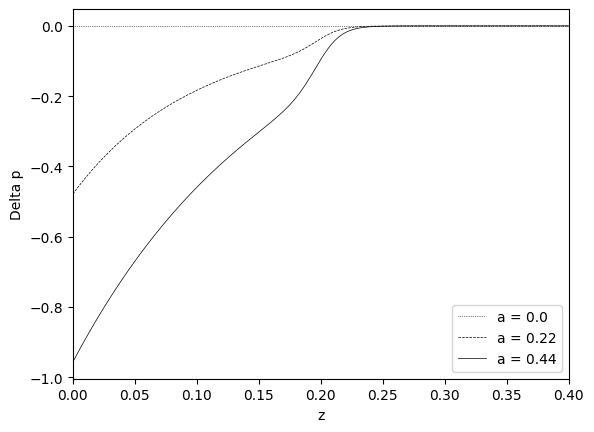

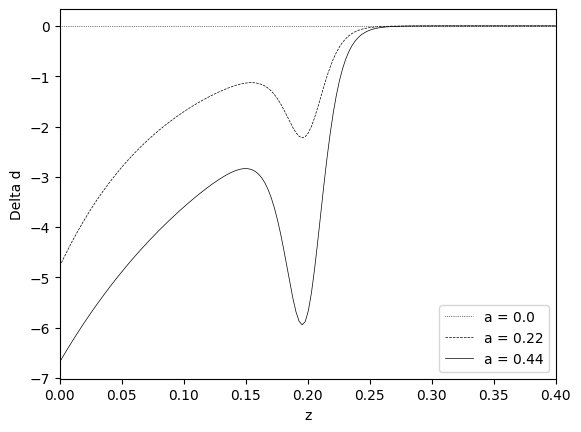

Pressure minimum mhs1 -0.06527585271067715
Pressure minimum mhs2 -0.26977672109442347
Density minimum mhs1 -2.2073631968891942
Density minimum mhs2 -5.926852906330043


In [7]:
# Figure 7

maxcoord = np.unravel_index(np.argmax(b_back, axis=None), b_back.shape)
iy = int(maxcoord[0])
ix = int(maxcoord[1])
backpres = 0.0 * z_arr
backden = 0.0 * z_arr
dpres1 = 0.0 * z_arr
dden1 = 0.0 * z_arr
dpres2 = 0.0 * z_arr
dden2 = 0.0 * z_arr
dpres3 = 0.0 * z_arr
dden3 = 0.0 * z_arr

for iz in range(nresol_z):
    z = z_arr[iz]
    backpres[iz] = bpressure(z, z0, deltaz, h, t0, t1)
    backden[iz] = bdensity(z, z0, deltaz, h, t0, t1)

    bz1 = bfield1[nresol_y + iy, nresol_x + ix, iz, 2]
    bzdotgradbz1 = (
        dbfield1[nresol_y + iy, nresol_x + ix, iz, 1] * bfield1[nresol_y + iy, nresol_x + ix, iz, 1]
        + bfield1[nresol_y + iy, nresol_x + ix, iz, 0] * bfield1[nresol_y + iy, nresol_x + ix, iz, 0]
        + bfield1[nresol_y + iy, nresol_x + ix, iz, 2] * bfield1[nresol_y + iy, nresol_x + ix, iz, 2]
    )

    bz2 = bfield2[nresol_y + iy, nresol_x + ix, iz, 2]
    bzdotgradbz2 = (
        dbfield2[nresol_y + iy, nresol_x + ix, iz, 1] * bfield2[nresol_y + iy, nresol_x + ix, iz, 1]
        + dbfield2[nresol_y + iy, nresol_x + ix, iz, 0] * bfield2[nresol_y + iy, nresol_x + ix, iz, 0]
        + dbfield2[nresol_y + iy, nresol_x + ix, iz, 2] * bfield2[nresol_y + iy, nresol_x + ix, iz, 2]
    )

    bz3 = bfield3[nresol_y + iy, nresol_x + ix, iz, 2]
    bzdotgradbz3 = (
        dbfield3[nresol_y + iy, nresol_x + ix, iz, 1] * bfield3[nresol_y + iy, nresol_x + ix, iz, 1]
        + dbfield3[nresol_y + iy, nresol_x + ix, iz, 0] * bfield3[nresol_y + iy, nresol_x + ix, iz, 0]
        + dbfield3[nresol_y + iy, nresol_x + ix, iz, 2] * bfield3[nresol_y + iy, nresol_x + ix, iz, 2]
    )

    backpres[iz] = bpressure(z, z0, deltaz, h, t0, t1)
    backden[iz] = bdensity(z, z0, deltaz, h, t0, t1)

    dpres1[iz] = deltapres(z, z0_b, deltaz_b, a1, b, bz1)
    dden1[iz] = deltaden(z, z0_b, deltaz_b, a1, b, bz1, bzdotgradbz1)
    dpres2[iz] = deltapres(z, z0_b, deltaz_b, a2, b, bz2)
    dden2[iz] = deltaden(z, z0_b, deltaz_b, a2, b, bz2, bzdotgradbz2)
    dpres3[iz] = deltapres(z, z0_b, deltaz_b, a3, b, bz3)
    dden3[iz] = deltaden(z, z0_b, deltaz_b, a3, b, bz3, bzdotgradbz3)

plt.plot(
    z_arr, dpres1, label="a = 0.0", linewidth=0.5, color="black", linestyle="dotted"
)
plt.plot(
    z_arr,
    dpres2,
    label="a = 0.22",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    dpres3,
    label="a = 0.44",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
"""plt.plot(
    z_arr,
    -0.5 * beta0 * backpres,
    linewidth=0.5,
    color="blue",
    linestyle="solid",
    label="Background pressure",
)"""
plt.legend()
plt.xlabel("z")
plt.ylabel("Delta p")
plt.xlim([0.0, 2 * z0_b])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure7a.png"
# plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr, dden1, label="a = 0.0", linewidth=0.5, color="black", linestyle="dotted"
)
plt.plot(
    z_arr,
    dden2,
    label="a = 0.22",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    dden3,
    label="a = 0.44",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
"""plt.plot(
    z_arr,
    -0.5 * beta0 / h * t0 / t_photosphere * backden,
    linewidth=0.5,
    color="blue",
    linestyle="solid",
    label="Background density",
)"""
plt.legend()
plt.xlabel("z")
plt.ylabel("Delta d")
plt.xlim([0.0, 2 * z0_b])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure7b.png"
# plt.savefig(plotname, dpi=300)
plt.show()

print("Pressure minimum mhs1", min(0.5 * beta0 * backpres + dpres2))
print("Pressure minimum mhs2", min(0.5 * beta0 * backpres + dpres3))
print(
    "Density minimum mhs1", min(0.5 * beta0 / h * t0 / t_photosphere * backden + dden2)
)
print(
    "Density minimum mhs2", min(0.5 * beta0 / h * t0 / t_photosphere * backden + dden3)
)

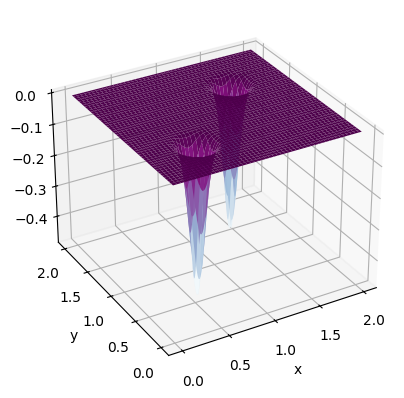

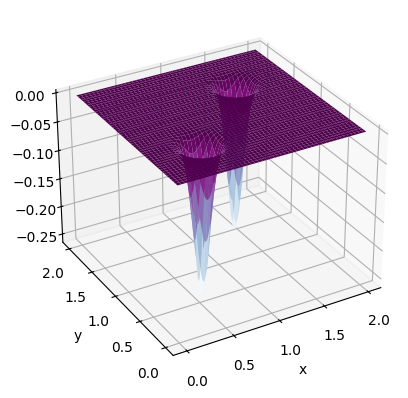

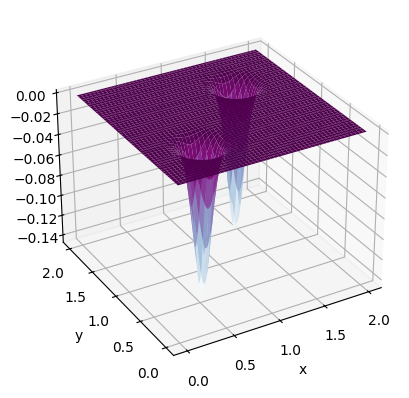

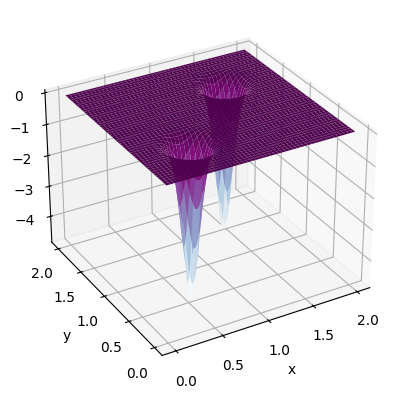

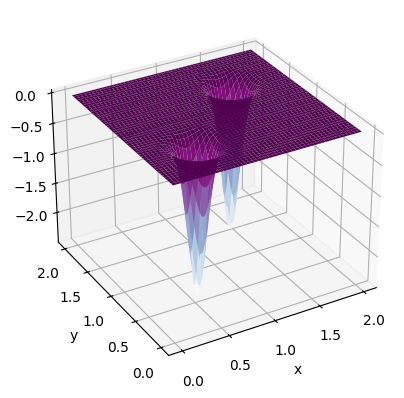

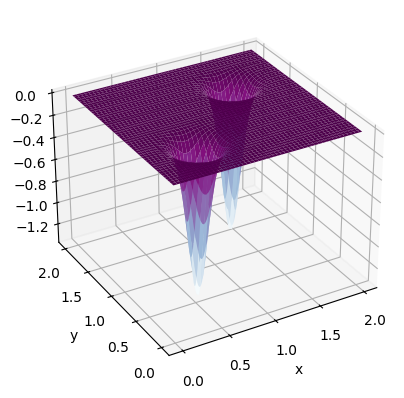

In [8]:
# Figure 8

dpres_photo = np.zeros((nresol_y, nresol_x))
dden_photo = np.zeros((nresol_y, nresol_x))

dpres_z0half = np.zeros((nresol_y, nresol_x))
dden_z0half = np.zeros((nresol_y, nresol_x))

dpres_z0 = np.zeros((nresol_y, nresol_x))
dden_z0 = np.zeros((nresol_y, nresol_x))

dpres_z0_bhalf = np.zeros((nresol_y, nresol_x))
dden_z0_bhalf = np.zeros((nresol_y, nresol_x))

dpres_z0_b = np.zeros((nresol_y, nresol_x))
dden_z0_b = np.zeros((nresol_y, nresol_x))

iz_photo = 0
z_photo = z_arr[iz_photo]

iz_z0half = 25
z_z0half = z_arr[iz_z0half]

iz_z0 = 50
z_z0 = z_arr[iz_z0]


for ix in range(nresol_x):
    for iy in range(nresol_y):
        bz_photo = bfield2[nresol_y + iy, nresol_x + ix, iz_photo, 2]
        bzdotgradbz_photo = (
            dbfield2[nresol_y + iy, nresol_x + ix, iz_photo, 1] * bfield2[nresol_y + iy, nresol_x + ix, iz_photo, 1]
            + dbfield2[nresol_y + iy, nresol_x + ix, iz_photo, 0] * bfield2[nresol_y + iy, nresol_x + ix, iz_photo, 0]
            + dbfield2[nresol_y + iy, nresol_x + ix, iz_photo, 2] * bfield2[nresol_y + iy, nresol_x + ix, iz_photo, 2]
        )
        dpres_photo[iy, ix] = deltapres(z_photo, z0_b, deltaz_b, a2, b, bz_photo)
        dden_photo[iy, ix] = deltaden(
            z_photo, z0_b, deltaz_b, a2, b, bz_photo, bzdotgradbz_photo
        )

        bz_z0half = bfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 2]
        bzdotgradbz_z0half = (
            dbfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 1] * bfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 1]
            + dbfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 0] * bfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 0]
            + dbfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 2] * bfield2[nresol_y + iy, nresol_x + ix, iz_z0half, 2]
        )
        dpres_z0half[iy, ix] = deltapres(z_z0half, z0_b, deltaz_b, a2, b, bz_z0half)
        dden_z0half[iy, ix] = deltaden(
            z_z0half, z0_b, deltaz_b, a2, b, bz_z0half, bzdotgradbz_z0half
        )

        bz_z0 = bfield2[nresol_y + iy, nresol_x + ix, iz_z0, 2]
        bzdotgradbz_z0 = (
            dbfield2[nresol_y + iy, nresol_x + ix, iz_z0, 1] * bfield2[nresol_y + iy, nresol_x + ix, iz_z0, 1]
            + dbfield2[nresol_y + iy, nresol_x + ix, iz_z0, 0] * bfield2[nresol_y + iy, nresol_x + ix, iz_z0, 0]
            + dbfield2[nresol_y + iy, nresol_x + ix, iz_z0, 2] * bfield2[nresol_y + iy, nresol_x + ix, iz_z0, 2]
        )
        dpres_z0[iy, ix] = deltapres(z_z0, z0_b, deltaz_b, a2, b, bz_z0)
        dden_z0[iy, ix] = deltaden(z_z0, z0_b, deltaz_b, a2, b, bz_z0, bzdotgradbz_z0)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot, x_plot, dpres_photo, cmap="BuPu", label="Delta p, z = " + str(z_photo)
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, 240, 0)
# ax.set_zlim([-0.5, 0.0])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure8a.png"
# plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot, x_plot, dpres_z0half, cmap="BuPu", label="Delta p, z = " + str(z_z0half)
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, 240, 0)
# ax.set_zlim([-0.5, 0.0])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure8c.png"
# plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot, x_plot, dpres_z0, cmap="BuPu", label="Delta p, z = " + str(z_z0)
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, 240, 0)
# ax.set_zlim([-0.5, 0.0])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure8e.png"
# plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot, x_plot, dden_photo, cmap="BuPu", label="Delta d, z = " + str(z_photo)
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, 240, 0)
# ax.set_zlim([-6.0, 0.0])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure8b.png"
# plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot, x_plot, dden_z0half, cmap="BuPu", label="Delta d, z = " + str(z_z0half)
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, 240, 0)
# ax.set_zlim([-6.0, 0.0])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure8d.png"
# plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(y_plot, x_plot, dden_z0, cmap="BuPu", label="Delta d, z = " + str(z_z0))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(30, 240, 0)
# ax.set_zlim([-6.0, 0.0])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure8f.png"
# plt.savefig(plotname, dpi=300)
plt.show()

0.2 0.02


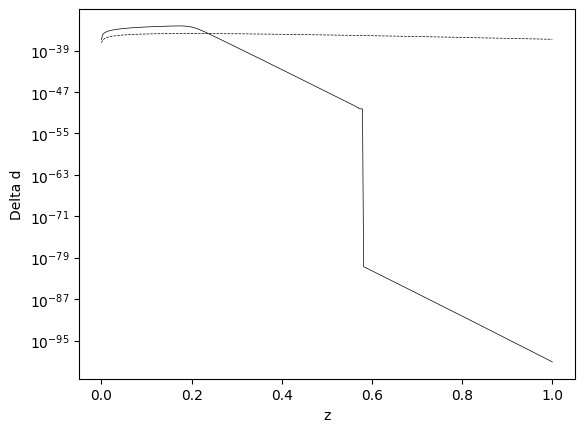

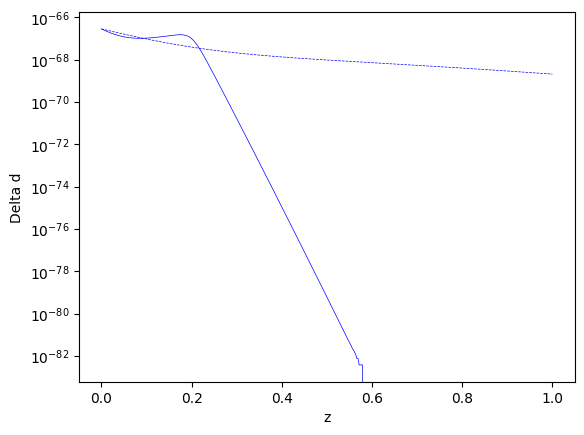

In [9]:
# Figure 9

a_low = a2 * (1 - np.tanh(-z0_b / deltaz_b))
kappa = 1.0 / z0_b

bfield_low = magnetic_field_low(
    data_bz,
    z0_b,
    kappa,
    a_low,
    b,
    alpha2,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

dfield_low = bz_partial_derivatives_low(
    data_bz,
    z0_b,
    kappa,
    a_low,
    b,
    alpha2,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
)

dpres_tanh = 0.0 * z_arr
dden_tanh = 0.0 * z_arr
dpres_low = 0.0 * z_arr
dden_low = 0.0 * z_arr
print(z0_b, deltaz_b)
for iz in range(nresol_z):
    z = z_arr[iz]
    bz_tanh = bfield2[nresol_y + iy, nresol_x + ix, iz, 2]
    bzdotgradbz_tanh = (
        dbfield2[nresol_y + iy, nresol_x + ix, iz, 1] * bfield2[nresol_y + iy, nresol_x + ix, iz, 1]
        + dbfield2[nresol_y + iy, nresol_x + ix, iz, 0] * bfield2[nresol_y + iy, nresol_x + ix, iz, 0]
        + dbfield2[nresol_y + iy, nresol_x + ix, iz, 2] * bfield2[nresol_y + iy, nresol_x + ix, iz, 2]
    )

    bz_low = bfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
    bzdotgradbz_low = (
        dfield_low[nresol_y + iy, nresol_x + ix, iz, 1] * bfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
        + dfield_low[nresol_y + iy, nresol_x + ix, iz, 0] * bfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
        + dfield_low[nresol_y + iy, nresol_x + ix, iz, 2] * bfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
    )

    dpres_tanh[iz] = deltapres(z, z0_b, deltaz_b, a2, b, bz_tanh)
    dpres_low[iz] = deltapres_low(z, kappa, a_low, bz_low)
    dden_tanh[iz] = deltaden(z, z0_b, deltaz_b, a2, b, bz_tanh, bzdotgradbz_tanh)
    dden_low[iz] = deltaden_low(z, kappa, a_low, bz_low, bzdotgradbz_low)
    #print("iz", iz, "z", z, "pressure", dpres_tanh[iz], "density", dden_tanh[iz])


plt.plot(z_arr, abs(dden_tanh), linewidth=0.5, color="black", linestyle="solid")
plt.plot(z_arr, abs(dden_low), linewidth=0.5, color="black", linestyle="dashed")
# plt.axvline(x=z0, color="black", linestyle="solid", linewidth=0.25)
# plt.legend()
plt.xlabel("z")
plt.ylabel("Delta d")
plt.yscale("log")
# plt.ylim([10**-20, 0.0])
# plt.xlim([0.4, 0.6])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure9b.png"
# plt.savefig(plotname, dpi=300)
plt.show()
plt.plot(z_arr, abs(dpres_tanh), linewidth=0.5, color="blue", linestyle="solid")
plt.plot(z_arr, abs(dpres_low), linewidth=0.5, color="blue", linestyle="dashed")
# plt.axvline(x=z0, color="black", linestyle="solid", linewidth=0.25)
# plt.legend()
plt.xlabel("z")
plt.ylabel("Delta d")
plt.yscale("log")
# plt.ylim([10**-20, 0.0])
# plt.xlim([0.4, 0.6])
# plotname = "/Users/lilli/Desktop/mflex/nw2019_paper/figure9b.png"
# plt.savefig(plotname, dpi=300)
plt.show()